# Introduction - unmask the NBA blackbox
 Sports industry is very developed in US. What are the secrets behind the high payoff of popular NBA players? What are the possible factors that affect NBA player’s salary?  The player’s basic information- like Age, Weight, Height? The player’s performance - Wins, PTS? Public comments and thoughts? Or even US Economic factors? 
 
 In the project, we are going to use data science methods to predict the NBA player's salary.


## Data sources

We collected data from multiple sources. 

1. We downloaded the player's basic biological data from kaggle. Link: https://www.kaggle.com/whitefero/nba-players-measurements-19472017

In [287]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [288]:
biodf= pd.read_excel("Player - Bio Stats (1947-2017).xlsx")

2. We dowloaded the player performance data from NBA official website. Link: https://stats.nba.com/players/traditional/?sort=PTS&dir=-1 

In [289]:
playerdf = pd.read_excel("Player Stats 96-18.xlsx")

3. We webscrapped the NBA player's salary from Hooshype. 

The following is scrapping code for salary data, it will take a long time to run, so we scrapped it in advance into the zip file. You could jump this step. And there is an alternative way below that allows you to read the salary data directly. 

In [290]:
# import requests
# from bs4 import BeautifulSoup
# url_head="https://hoopshype.com/salaries/players/"
# def get_salary_data(url=url_head):
#     lst=[0,]
#     df=pd.DataFrame([],columns=['Name','Year','Salary'])
#     for i in range(1990,2018):
#         response = requests.get(url+str(i)+'-'+str(i+1)+'/')
#         try:
#             results_page = BeautifulSoup(response.content,'lxml')
#             players = results_page.find_all('tr')[1:]
#             year = str(i)+'-'+str(i+1)
#             for j,player in enumerate(players):
#                 tds = player.find_all('td')
#                 player_name = tds[1].get_text().strip()
#                 df.loc[j+lst[-1],'Name'] = player_name
#                 ori_sal = tds[2].get_text().strip()
#                 df.loc[j+lst[-1],'Salary'] = ori_sal
#                 df.loc[j+lst[-1],'Year'] = year
#             lst.append(len(players)+lst[-1])
#         except:
#             return None
#     response = requests.get(url)
#     results_page = BeautifulSoup(response.content,'lxml')
#     players = results_page.find_all('tr')[1:]
#     year = '2019'+'-'+'2020'
#     for j,player in enumerate(players):
#         tds = player.find_all('td')
#         player_name = tds[1].get_text().strip()
#         df.loc[j+lst[-1],'Name'] = player_name
#         ori_sal = tds[2].get_text().strip()
#         df.loc[j+lst[-1],'Salary'] = ori_sal
#         df.loc[j+lst[-1],'Year'] = year
#     lst.append(len(players)+lst[-1])
#     return df

Data Cleaning for scrapped data

In [291]:
# salarydf=get_salary_data()
# salarydf["Year"]=salarydf["Year"].apply(lambda x: x[0:4])
# salarydf["Salary"]=salarydf["Salary"].apply(lambda x: x[1:].replace(",",""))
# salarydf=salarydf.astype({"Year":"int64","Salary":"int64"})

Alternative way to read the salary dataset

In [292]:
salarydf = pd.read_excel("Hoopshype player salary 90-19.xlsx")

## Data Cleaning & Preprocessing & Visulization

### <li>Data Cleaning within raw data

#### 1. For biological dataset, we found few attributes are complete. So we selected 4 attributes from the biodf based on the data integrity. They are "Player Full Name", "Position", "Height (in cm)" and "Weight (in lb)".

In [294]:
biodf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4501 entries, 0 to 4500
Data columns (total 15 columns):
Player Full Name           4501 non-null object
Birth Date                 4501 non-null object
Year Start                 4501 non-null int64
Year End                   4501 non-null int64
Position                   4500 non-null object
Height (ft 1/2)            4500 non-null float64
Height (inches 2/2)        4500 non-null float64
Height (in cm)             4501 non-null float64
Wingspan (in cm)           746 non-null float64
Standing Reach (in cm)     746 non-null float64
Hand Length (in inches)    348 non-null float64
Hand Width (in inches)     348 non-null float64
Weight (in lb)             4495 non-null float64
Body Fat (%)               621 non-null float64
College                    4200 non-null object
dtypes: float64(9), int64(2), object(4)
memory usage: 527.5+ KB


In [295]:
biodf=biodf[["Player Full Name", "Position", "Height (in cm)", "Weight (in lb)"]]# select the 4 columns
biodf.columns=["Player Full Name", "Position", "Height", "Weight"] #change the column name

#### 2. For salary dataset, we did the following 4 things:

<li> Use CPI to unify salary in 2019 context. The CPI index is captured from official website of US Bureau of Labor Statistics Website.


In [296]:
inflation_dict={1990: 1.97, 1991: 1.89, 1992: 1.83,1993:1.78, 1994:1.74, 1995: 1.69, 1996: 1.6402, 1997: 1.6034, 1998:1.5788, 1999:1.5447, 2000:1.4945, 2001:1.4531, 2002:1.4305, 
                2003: 1.3986, 2004:1.3623, 2005:1.3177, 2006:1.2765, 2007:1.2412, 2008:1.1953, 2009:1.1995,
                2010: 1.1802, 2011:1.1441, 2012:1.1209, 2013:1.1047, 2014:1.0871, 2015:1.0858, 2016:1.0722,
                2017: 1.0499, 2018:1.0248, 2019:1}

In [297]:
salarydf["Salary2019"] = salarydf['Salary'] * salarydf['Year'].apply(lambda x: inflation_dict[x])
#creat a new column salary2019 

<li> Shift salary to match with last year performance, since we should use player's performance in 2017 to predict 2018's salary

In [298]:
salarydf["Year"]=salarydf["Year"].apply(lambda x: x-1)  

<li> Adding one feature: tenure

In [299]:
year_start = salarydf.groupby("Name")['Year'].min() #group by player and get min to find their start year
year_start = year_start.reset_index() 
salarydf = pd.merge(salarydf, year_start, left_on = 'Name', right_on = 'Name', suffixes = ('','_start')) 
#merge with original to add the start year column
salarydf['tenure'] = salarydf['Year'] - salarydf['Year_start'] 
#denote the tenure as 'current year' - 'start year'
salarydf = salarydf.drop('Year_start',axis=1) 

<li> Clean the name column, delete hidden space

In [300]:
salarydf['Name'] = salarydf['Name'].apply(lambda x: x.strip())

#### 3. For player performance dataset, we found the team name is not consistent with time, we searched the internet about the history of different teams and decided to use the latest name for each team to replace all past names.

In [301]:
# The conditions are past possible team names, and the return value is the latest team name
def change(team):
    if team == "NJN":
        return "BKN"
    if team == "CHH":
        return "CHA"
    if team == "NOH" or team == "NOK":
        return "NOP"
    if team == "VAN":
        return "MEM"
    if team == "SEA":
        return "OKC"
    else:
        return team

In [302]:
playerdf['TEAM'] = playerdf['TEAM'].apply(change)

### <li>Merge 3 datasets - biodf, salarydf and playerdf

#### 1. Merge salary dataset and player performance dataset to df1

In [303]:
df1=pd.merge(salarydf,playerdf,left_on=["Name", "Year"],right_on=["Player","Year"])

In [304]:
salarydf.shape

(13968, 5)

In [305]:
playerdf.shape

(10543, 30)

In [306]:
df1.shape

(7998, 34)

We found there are a lot of rows missing after first merging.  We doubted that some players' name may not be consistent among different datasets. Using the following code, we first left merge and then right merge the 2 datasets to select the names that not matched with each other. 

In [307]:
df2=pd.merge(salarydf,playerdf,left_on=["Name"],right_on=["Player"], how="left")
df2[df2.isnull().T.any()].head()

,Year_x,Name,Salary,Salary2019,tenure,Year_y,Player,TEAM,AGE,GP,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-
90,1994,James Worthy,5150000,8703500.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,1994,Sam Bowie,4800000,8112000.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,1994,Brad Daugherty,4700000,7943000.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,1994,Clarence Weatherspoon,4500000,7605000.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,1994,John Williams,4151000,7015190.0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [308]:
df3=pd.merge(salarydf,playerdf,left_on=["Name"],right_on=["Player"], how="right")
df3[df3.isnull().T.any()].head()

,Year_x,Name,Salary,Salary2019,tenure,Year_y,Player,TEAM,AGE,GP,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-
99458,NaN,NaN,NaN,NaN,NaN,1996,Clar. Weatherspoon,PHI,26,82,...,8.3,1.7,1.7,0.9,1.0,2.3,28.9,22,0,-6.0
99459,NaN,NaN,NaN,NaN,NaN,1997,Clar. Weatherspoon,GSW,27,79,...,7.5,1.1,1.5,1.1,0.9,2.5,24.6,11,0,-1.9
99460,NaN,NaN,NaN,NaN,NaN,1998,Clar. Weatherspoon,MIA,28,49,...,5.0,0.7,1.2,0.6,0.3,2.2,16.6,1,0,1.0
99461,NaN,NaN,NaN,NaN,NaN,1999,Clar. Weatherspoon,MIA,29,78,...,5.8,1.2,1.3,0.7,0.6,2.1,18.5,7,0,0.7
99462,NaN,NaN,NaN,NaN,NaN,2000,Clar. Weatherspoon,CLE,30,82,...,9.7,1.3,1.4,1.0,1.3,2.1,30.4,25,0,-3.3


We exported the above two datasets and compared the differences in the name expression, and build a new dataset: namedifference with 2 columns, "Original Name" and "Name". Using that dataset, we updated the name expression in the salary dataset to be consistent with the player performance dataset.

In [309]:
salarychangedf=pd.read_excel("name change.xlsx")

salarychangedf['Origin Name'] = salarychangedf['Origin Name'].apply(lambda x: x.strip())


salarydict=dict()
for i in range(0,salarychangedf.shape[0]):# build a namechange dictionary using the dataset namechange
    salarydict[salarychangedf.iloc[i,0]]= salarychangedf.iloc[i,1] 

def change_salary(name):
    if name in salarydict.keys():
        return salarydict[name]
    else:    
        return name

salarydf['Name'] = salarydf['Name'].apply(change_salary) #Update the name expression in the salary dataset
salarydf['Name'] = salarydf['Name'].apply(lambda x: x.strip())

Then we tried to remerge salary dataset and player performance dataset to df1

In [310]:
df1=pd.merge(salarydf,playerdf,left_on=["Name", "Year"],right_on=["Player","Year"])

#### 2. Merge df1 with biological df to df

Similarly, we first left merge and then right merge the 2 datasets to find the name expression differences. And we updated it directly in the biological dataset. So we directly merged the two datasets this time.

In [311]:
merged_df=pd.merge(df1,biodf,left_on=["Name"],right_on=["Player Full Name"],how="inner")
# We get the merged dataset

We found there are a lot of repeated columns. Therefore we droped some columns.

In [312]:
merged_df.columns 

Index(['Year', 'Name', 'Salary', 'Salary2019', 'tenure', 'Player', 'TEAM',
       'AGE', 'GP', 'W', 'L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
       'BLK', 'PF', 'FP', 'DD2', 'TD3', '+/-', 'Player Full Name', 'Position',
       'Height', 'Weight'],
      dtype='object')

In [313]:
merged_df=merged_df.drop(["L","Salary","Player","Player Full Name"],axis=1)

In [314]:
merged_df.columns

Index(['Year', 'Name', 'Salary2019', 'tenure', 'TEAM', 'AGE', 'GP', 'W', 'MIN',
       'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%',
       'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2',
       'TD3', '+/-', 'Position', 'Height', 'Weight'],
      dtype='object')

In [315]:
merged_df.shape

(8117, 34)

### <li>Replace the dependent variable 

After getting the merged dataset, firstly we found a problem is that although preprocessed by CPI, the average NBA salary still significantly increased over the past 20 years. 

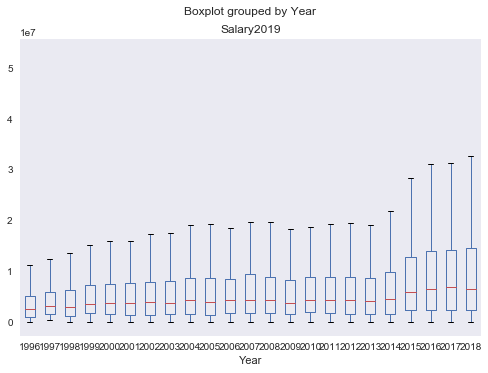

In [316]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

merged_df.boxplot(by ='Year', column =['Salary2019'], grid = False) # the boxplot of salary2019 in each year

The possible reason could be the economic influence among different years. So we decided to normalize the salary data by putting it as a percentage of the <b> league’s salary cap, the total salary limit that a team can spend on its players in a given season</b>, which intuitively will eliminate the year economic influence in salary. 


We captured the salary cap of different years from NBA official website and build the following dictionary. Using that, we get a new column: Salary_Weight


In [317]:
SalaryCapDict={2019:109140000, 2018: 101869000, 2017: 99093000, 2016: 94143000, 2015: 70000000, 2014: 63065000, 2013: 58679000, 
               2012: 58044000, 2011: 58044000, 2010: 58044000, 2009: 57700000, 2008: 58680000, 2007: 55630000,
               2006: 53135000, 2005: 49500000, 2004: 43870000, 2003: 43840000, 2002: 40271000, 2001: 42500000,
               2000: 35500000, 1999: 34000000, 1998: 30000000, 1997: 26900000, 1996: 24363000}


inflation_dict={1996: 1.6402, 1997: 1.6034, 1998:1.5788, 1999:1.5447, 2000:1.4945, 2001:1.4531, 2002:1.4305, 
                2003: 1.3986, 2004:1.3623, 2005:1.3177, 2006:1.2765, 2007:1.2412, 2008:1.1953, 2009:1.1995,
                2010: 1.1802, 2011:1.1441, 2012:1.1209, 2013:1.1047, 2014:1.0871, 2015:1.0858, 2016:1.0722,
                2017: 1.0499, 2018:1.0248, 2019: 1}

merged_df["Salary_Weight"]=merged_df["Salary2019"]/merged_df["Year"].apply(lambda x: inflation_dict[x+1]*SalaryCapDict[x+1])

As expected, the year influence in salary is almost eliminated, so we decided to use Salary_Weight as our new dependent variable.

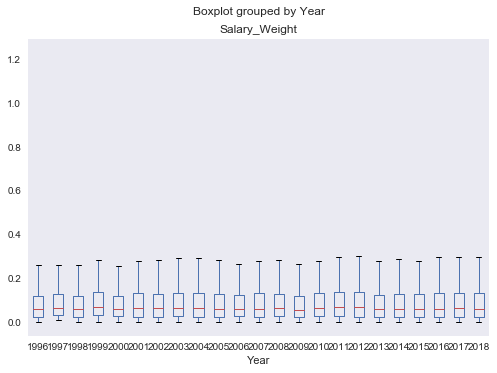

In [318]:
merged_df.boxplot(by ='Year', column =['Salary_Weight'], grid = False)

In [319]:
merged_df=merged_df.drop(["Salary2019"],axis=1) 

### <li>Data Visulization 

#### Deep down, we did more visulization on our dataset.

The two following plots indicate that the merged data we get is pretty flat among different teams and years

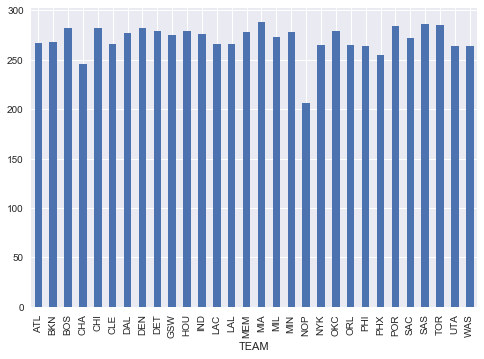

In [320]:
merged_df.groupby("TEAM").size().plot(kind='bar')

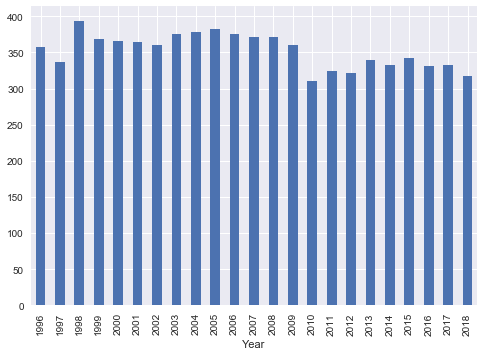

In [321]:
merged_df.groupby("Year").size().plot(kind='bar')

We drawed the Salary_Weight mean trend group by teams over the 20 years. 

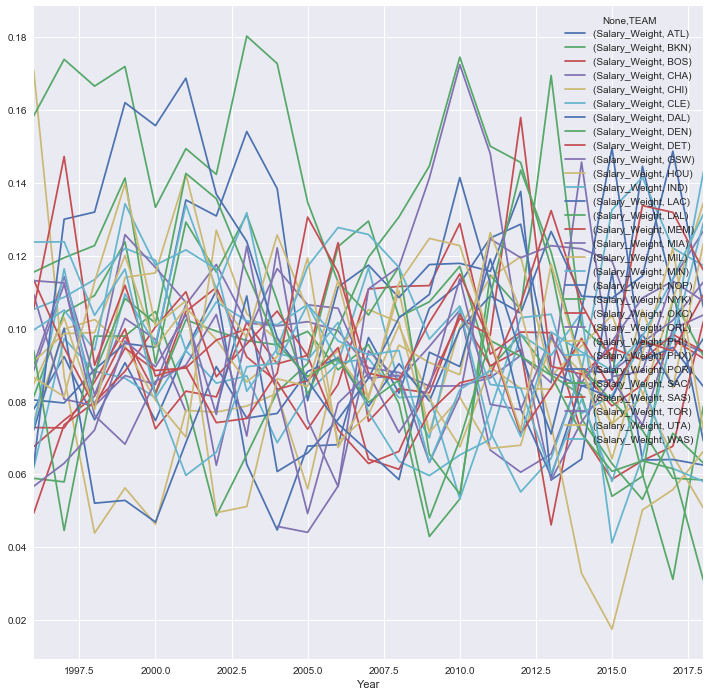

In [322]:
date_agency = merged_df[["TEAM","Year","Salary_Weight"]].groupby(['Year','TEAM'])
dt=date_agency
dt.mean().unstack().plot(kind='line',figsize=(12,12))

We drawed the correlation matrix, and found that the independent attributes are not highly correlated

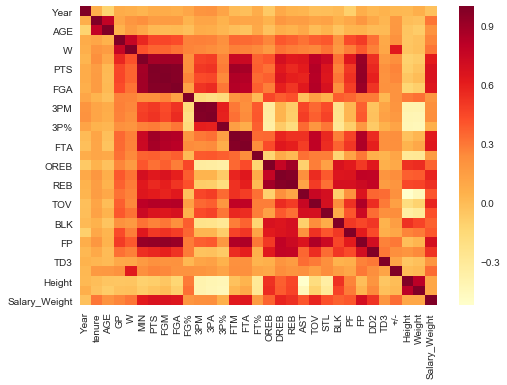

In [323]:
import seaborn as sns
sns.heatmap(merged_df.corr(), cmap="YlOrRd")

#### All visulization results showed that there were no more problems in our dataset.

#### Finally, we got the cleaned data, and it's time to analyze it using maching learning algorithms

## Machine Learning Algorithms under different models

We've used 3 models under different assumptions:
1. <b>Baseline Model</b> - The rationale of salary decision does not change over time
2. <b>Auto-Regression Model</b> - Previous year salary might serve as a reference of decision
3. <b>Time-Lagged Feature Model</b> - Previous years' performance and salary both contribute to the new decision



For each model, we employed the following Machine Learning Algorithms:


<li><b>Linear Regression
<li>Decision Tree & Random Forest & Bagging
<li>Gradient Boosting Machine & XGBoost
<li>Support Vector Machine
<li>Neural Network </b>
    
In the meanwhile, we used grid search to select the best parameters for each Machine Learning model, and used cross validation RMSE (Root Mean Squared Error) as a comparing line among different models.

### 1.Baseline Model

We first splited the data into training set and testing set

In [324]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(merged_df, test_size = 0.2)
x_train_baseline = train.drop(["Name" ,"Salary_Weight"],axis=1) 
y_train_baseline = train['Salary_Weight']
x_test_baseline = test.drop(["Name","Salary_Weight"],axis=1)
y_test_baseline = test['Salary_Weight']

Then transformed the qualitative attributes into dummy variables

In [325]:
x_train_baseline.dummies=pd.get_dummies(x_train_baseline,columns=['Position','TEAM','Year'],drop_first=True)
x_test_baseline.dummies=pd.get_dummies(x_test_baseline,columns=['Position','TEAM','Year'],drop_first=True)

#### <li>Linear regression (with a 10-fold Cross Validation)

In [326]:
from sklearn import linear_model
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error
import math

kf = KFold(n_splits=10, random_state=None) 
RMSE=list()
for train_index, test_index in kf.split(x_train_baseline.dummies):
    X_train, X_test = x_train_baseline.dummies.iloc[train_index], x_train_baseline.dummies.iloc[test_index] 
    Y_train, Y_test = y_train_baseline.iloc[train_index], y_train_baseline.iloc[test_index]
    model = linear_model.LinearRegression()
    model.fit(X_train,Y_train)
    testing_predictions  = model.predict(X_test)
    RMSE.append(math.sqrt(mean_squared_error(Y_test,testing_predictions)))
rmse_lr_baseline=sum(RMSE)/len(RMSE)
rmse_lr_baseline

0.05780444649049565

#### <li>Decision Tree
    '''Grid Search will a long time to run'''

In [327]:
'''Our best model parameters are max depth: 10, and min_sample_split: 45 with a cv RMSE = 0.06533055468869442'''

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
parameters = {
     'max_depth': [10,50,100,500],
     'min_samples_split': [15,25,35,45],
     
}  
model = GridSearchCV(DecisionTreeRegressor(), param_grid = parameters,scoring='neg_mean_squared_error'
                     ,cv=10,iid=False)
model.fit(x_train_baseline.dummies, y_train_baseline)
rmse_dt_baseline=math.sqrt(-model.best_score_)
rmse_dt_baseline,model.best_params_


(0.06533055468869442, {'max_depth': 10, 'min_samples_split': 45})

#### <li>Random Forest
     '''Grid Search will take a long time to run'''

In [329]:
'''Our best model parameters are n_estimators: 500, max depth: 10, max_features: 40, and min_sample_split: 10, 
   with a cv RMSE = 0.053942456405754055'''

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

parameters = {
     'n_estimators': (10,20,50,80,100,200,300,500), #the number of trees
     'max_depth': [10,20,30,50, 100],
     'max_features': (10, 20, 30, 40),
     'min_samples_split': [10,20,30,50,100],
     
}  
model = GridSearchCV(RandomForestRegressor(), param_grid = parameters,scoring='neg_mean_squared_error'
                     ,cv=10,iid=False)
model.fit(x_train_baseline.dummies, y_train_baseline)
rmse_rf_baseline=math.sqrt(-model.best_score_)
rmse_rf_baseline, model.best_params_

<b> We run the best Random Forest Model to inspect the feature importances

Text(0.5, 0, 'Relative Importance')

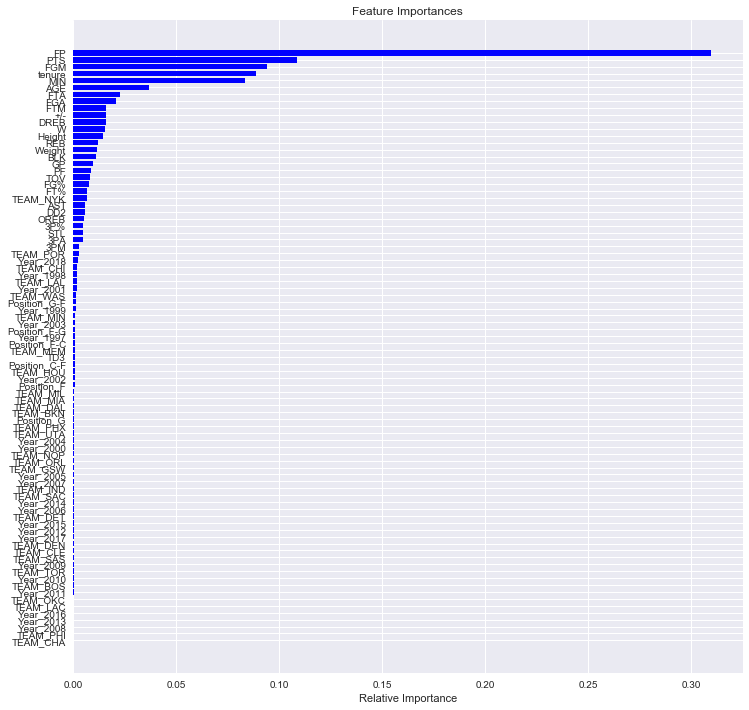

In [330]:
import matplotlib.pyplot as plt
%matplotlib inline
rf = RandomForestRegressor(n_estimators=500,max_depth=10,max_features=40,min_samples_split=10)
rf.fit(x_train_baseline.dummies, y_train_baseline)
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')

feature_importance_rf=pd.DataFrame(data=[x_train_baseline.dummies.columns,rf.feature_importances_],
                                index=["features","importances"], columns=None, dtype=None, copy=False).T
feature_importance_rf.sort_values("importances", inplace=True)

plt.yticks(range(len(indices)),feature_importance_rf["features"])
plt.xlabel('Relative Importance')

<b>After comparing feature importance of random forest, mostly the less important variables are dummy variables, we decided to drop the attributes: "TEAM", "Year", "Position","TD3","3PM"

In [331]:
merged_df=merged_df.drop(["TEAM","Position","TD3","3PM"],axis=1) 
dfnew=merged_df.drop(["Year"],axis=1) # drop attributes "TEAM","Year","Position","TD3","3PM"
from sklearn.model_selection import train_test_split
train, test = train_test_split(dfnew, test_size = 0.2)
x_train_baseline = train.drop(["Name","Salary_Weight"],axis=1)
y_train_baseline = train['Salary_Weight']
x_test_baseline = test.drop(["Name","Salary_Weight"],axis=1)
y_test_baseline = test['Salary_Weight']


####  <li>Bagging
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are n_estimators: 500, max_samples: 2000, and max_features: 20,
   with a cv RMSE = 0.05517725068469039'''

from sklearn.ensemble import BaggingRegressor

parameters = {
     'n_estimators':[10,20,50,80,100,200,300,500], #the number of trees
     'max_samples':[100, 500, 1000, 2000], 
     'max_features':[5,10,15,20],
}

model = GridSearchCV(BaggingRegressor(),parameters,cv=10,iid=False,scoring='neg_mean_squared_error')
model.fit(x_train_baseline, y_train_baseline)
rmse_bg_baseline=math.sqrt(-model.best_score_)
rmse_bg_baseline, model.best_params_

#### <li>Gradient Boosting Regressor
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are loss: lad, n_estimators: 500, max_depth: 10, max_features: 20, min_samples_split: 20,
   learning_rate': 0.1 with a cv RMSE = 0.054748942313339745'''

from sklearn.ensemble import GradientBoostingRegressor

parameters = {
     'loss':('ls','lad'),
     'n_estimators': [10,20,50,80,100,200,300,500], #the number of trees
     'max_depth': [10,20,50,100],
     'max_features': [5,10,15,20],
     'min_samples_split': [10,20,30,50,100],
     'learning_rate':[0.1,0.2,0.5],
}  

gbr = GridSearchCV(GradientBoostingRegressor(), param_grid = parameters, scoring='neg_mean_squared_error',cv=10, iid=False)
gbr.fit(x_train_baseline, y_train_baseline)
rmse_gbr_baseline=math.sqrt(-gbr.best_score_)
rmse_gbr_baseline, gbr.best_params_


#### <li> XGBoost
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are loss: colsample_bytree: 0.5, learning_rate: 0.1, max_depth: 10,
   n_estimators: 500, objective: reg:squarederror with a cv RMSE = 0.05401895110041065'''

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

parameters = {
     'objective':['reg:squarederror'],
     'n_estimators': [10,20,50,80,100,200,300,500], #the number of trees
     'max_depth': [10,20,50,100],
     'colsample_bytree': [0.1, 0.5, 0.7],
     'learning_rate':[0.1,0.2,0.5],
}  

xg_reg = xgb.XGBRegressor()
xgb = GridSearchCV(xg_reg, param_grid = parameters, scoring='neg_mean_squared_error',cv=10, iid=False)
xgb.fit(x_train_baseline, y_train_baseline)
rmse_xgb_baseline=math.sqrt(-xgb.best_score_)
rmse_xgb_baseline,xgb.best_params_

#### <li>SVR
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are gamma: scale, epsilon: 0.05, and C: 1 with a cv RMSE = 0.058715015021951686'''

from sklearn.svm import SVR
parameters = {
     'gamma': ["scale", "auto"],
     'C': [0.1, 0.3, 0.5, 0.8, 1],
     'epsilon': (0.05, 0.1, 0.2, 0.4, 0.6, 0.8),    
}  

model = GridSearchCV(SVR(), param_grid = parameters,scoring='neg_mean_squared_error'
                     ,cv=10,iid=False)
model.fit(x_train_baseline, y_train_baseline)
rmse_svr_baseline=math.sqrt(-model.best_score_)
rmse_svr_baseline, model.best_params_


#### <li>Neural Network
     '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are learning_rate: adaptive, solver: adam, activation: relu, hidden_layer_sizes: 3, max_iter: 10000,
    with a cv RMSE = 0.4732440942437857'''

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
parameters = {
    'learning_rate':["adaptive", "invscaling", "adaptive"],
    'solver': ['adam','lbfgs','adam'],
    'activation': ['relu'],
    'hidden_layer_sizes': [(2,),(3,),(5,),(15,),(30,),(60,),(80,)], 
    'max_iter': [10000],
}
gs = GridSearchCV(estimator = MLPRegressor(), param_grid=parameters,cv=10)
gs.fit(x_train_baseline, y_train_baseline)
rmse_nn_baseline=math.sqrt(-gs.best_score_)
rmse_nn_baseline, gs.best_params_

### 2. Auto-Regression Model

<b>We guess that previous year salary might also serve as a reference of decision. So we decided to include one attribute: 'salary_weight_l' to denote player's salary from last year 


In [332]:
#Adding one attribute Salary_Weight_l"
slag = merged_df[['Name','Year','Salary_Weight']].copy()
slag['Year'] = slag['Year'].apply(lambda x: x+1)
df_ar = merged_df.merge(slag, left_on = ['Name','Year'], right_on = ['Name','Year'], suffixes = ('','_l')).copy() 

#### Split the data into training set and testing set

In [333]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_ar, test_size = 0.2)
x_train_ar = train.drop(["Name", "Year","Salary_Weight"],axis=1) 
y_train_ar = train['Salary_Weight']
x_test_ar = test.drop(["Name", "Year","Salary_Weight"],axis=1)
y_test_ar = test['Salary_Weight']


#### <li>Linear regression (with 10-fold cross validation)

In [334]:
from sklearn import linear_model
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error
import math

kf = KFold(n_splits=10, random_state=None) 
RMSE=list()
for train_index, test_index in kf.split(x_train_ar):
    X_train, X_test = x_train_ar.iloc[train_index], x_train_ar.iloc[test_index] 
    Y_train, Y_test = y_train_ar.iloc[train_index], y_train_ar.iloc[test_index]
    model = linear_model.LinearRegression()
    model.fit(X_train,Y_train)
    testing_predictions  = model.predict(X_test)
    RMSE.append(math.sqrt(mean_squared_error(Y_test,testing_predictions)))
rmse_lr_ar=sum(RMSE)/len(RMSE)
rmse_lr_ar

0.04360740345912279

#### <li>Decision Tree
     '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are max depth: 10, and min_sample_split: 45 with a cv RMSE = 0.04798989450011509'''

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
parameters = {
     'max_depth': [10,50,100,500],
     'min_samples_split': [15,25,35,45],
     
}  
model = GridSearchCV(DecisionTreeRegressor(), param_grid = parameters,scoring='neg_mean_squared_error'
                     ,cv=10,iid=False)
model.fit(x_train_ar, y_train_ar)
rmse_dt_ar=math.sqrt(-model.best_score_)
rmse_dt_ar,model.best_params_


#### <li>Random Forest
      '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are n_estimators: 500, max depth: 10, max_features: 20, and min_sample_split: 10, 
   with a cv RMSE = 0.04179852438392675'''

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

parameters = {
     'n_estimators': (10,20,50,80,100,200,300,500), #the number of trees
     'max_depth': [10,20,30,50, 100],
     'max_features': [5,10,15,20],
     'min_samples_split': [10,20,30,50,100],
     
}  
model = GridSearchCV(RandomForestRegressor(), param_grid = parameters,scoring='neg_mean_squared_error'
                     ,cv=10,iid=False)
model.fit(x_train_ar, y_train_ar)
rmse_rf_ar=math.sqrt(-model.best_score_)
rmse_rf_ar, model.best_params_

#### <li>Bagging
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are n_estimators: 500, max_samples: 2000, and max_features: 20,
   with a cv RMSE = 0.043002680422742384'''

from sklearn.ensemble import BaggingRegressor

parameters = {
     'n_estimators':[10,20,50,80,100,200,300,500], #the number of trees
     'max_samples':[100, 500, 1000, 2000], 
     'max_features':[5,10,15,20],
}

model = GridSearchCV(BaggingRegressor(),parameters,cv=10,iid=False,scoring='neg_mean_squared_error')
model.fit(x_train_ar, y_train_ar)
rmse_bg_ar=math.sqrt(-model.best_score_)
rmse_bg_ar, model.best_params_

#### <li>Gradient Boosting Regressor
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are loss: lad, n_estimators: 500, max_depth: 10, max_features: 20, min_samples_split: 20,
   learning_rate': 0.1 with a cv RMSE = 0.04290870373420928'''

from sklearn.ensemble import GradientBoostingRegressor

parameters = {
     'loss':('ls','lad'),
     'n_estimators':[10,20,50,80,100,200,300,500], #the number of trees
     'max_depth': [10,20,50,100],
     'max_features': [5,10,15,20],
     'min_samples_split': [10,20,30,50,100],
     'learning_rate':[0.1,0.2,0.5],
}  

gbr = GridSearchCV(GradientBoostingRegressor(), param_grid = parameters, scoring='neg_mean_squared_error',cv=10, iid=False)
gbr.fit(x_train_ar, y_train_ar)
rmse_gbr_ar=math.sqrt(-gbr.best_score_)
rmse_gbr_ar, gbr.best_params_


#### <li>XGBoost
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are loss: colsample_bytree: 0.5, learning_rate: 0.1, max_depth: 10,
   n_estimators: 500, objective: reg:squarederror with a cv RMSE = 0.04423872686763274'''

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

parameters = {
     'objective':['reg:squarederror'],
     'n_estimators': [10,20,50,80,100,200,300,500], #the number of trees
     'max_depth': [10,20,50,100],
     'colsample_bytree': [0.1, 0.5, 0.7],
     'learning_rate': [0.1,0.2,0.5],
}  

xg_reg = xgb.XGBRegressor()
xgb = GridSearchCV(xg_reg, param_grid = parameters, scoring='neg_mean_squared_error',cv=10, iid=False)
xgb.fit(x_train_ar, y_train_ar)
rmse_xgb_ar=math.sqrt(-xgb.best_score_)
rmse_xgb_ar,xgb.best_params_

#### <li>SVR
    '''Grid Search will take  a long time to run'''

In [ ]:
'''Our best model parameters are gamma: scale, epsilon: 0.05, and C: 1 with a cv RMSE = 0.06063064788408325'''

from sklearn.svm import SVR
parameters = {
     'gamma': ["scale","auto"],
     'C': [0.1, 0.3, 0.5, 0.8, 1],
     'epsilon': (0.05, 0.1, 0.2, 0.4, 0.6, 0.8)    
}  

model = GridSearchCV(SVR(), param_grid = parameters,scoring='neg_mean_squared_error'
                     ,cv=10,iid=False)
model.fit(x_train_ar, y_train_ar)
rmse_svr_ar=math.sqrt(-model.best_score_)
rmse_svr_ar, model.best_params_



#### <li>Neural Network
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are learning_rate: adaptive, solver: adam, activation: relu, hidden_layer_sizes: 3,
   max_iter: 10000, with a cv RMSE = 0.4071442026764561'''

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
parameters = {
    'learning_rate':["adaptive",  "invscaling", "adaptive"],
    'solver': ['adam','lbfgs','adam'],
    'activation': ['relu'],
    'hidden_layer_sizes': [(2,),(3,),(5,),(15,),(30,),(60,),(80,)], 
    'max_iter': [10000],
}
gs = GridSearchCV(estimator = MLPRegressor(), param_grid=parameters,cv=10)
gs.fit(x_train_ar, y_train_ar)
rmse_nn_ar=math.sqrt(-gs.best_score_)
rmse_nn_ar, gs.best_params_

Since Neural Network performs extremly bad in both 2 models, we decided to drop it in the following models

### 3. Lagged Feature Model - lag 1 year


#### Deep down, we guessed that previous year performance and salary may both contribute to the new decision. So we first created 1-year lag for performance variables to capture previous performance


In [ ]:
lag1 = merged_df[['Name', 'Year', 'GP', 'W', 'MIN', 'PTS', 'FGM','FGA', 'FG%', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB','REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', '+/-']].copy()
lag1['Year'] = lag1['Year'].apply(lambda x: x+1)

In [ ]:
df_lag1 = df_ar.merge(lag1, left_on = ['Name','Year'], right_on = ['Name','Year'], suffixes = ('', '_l1')).copy()

#### Split the data into training set and testing set

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_lag1, test_size = 0.2)
x_train_lag1 = train.drop(['Name','Year','Salary_Weight'],axis=1) 
y_train_lag1 = train['Salary_Weight']
x_test_lag1 = test.drop(['Name','Year','Salary_Weight'],axis=1)
y_test_lag1 = test['Salary_Weight']


#### <li>Linear regression (with a 10-fold Cross validation)

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error
import math

kf = KFold(n_splits=10, random_state=None) 
RMSE=list()
for train_index, test_index in kf.split(x_train_lag1):
    X_train, X_test = x_train_lag1.iloc[train_index], x_train_lag1.iloc[test_index] 
    Y_train, Y_test = y_train_lag1.iloc[train_index], y_train_lag1.iloc[test_index]
    model = linear_model.LinearRegression()
    model.fit(X_train,Y_train)
    testing_predictions  = model.predict(X_test)
    RMSE.append(math.sqrt(mean_squared_error(Y_test,testing_predictions)))
rmse_lr_lag1=sum(RMSE)/len(RMSE)
rmse_lr_lag1

#### <li>Decision Tree
     '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are max depth: 10, and min_sample_split: 45 with a cv RMSE = 0.049326163791676876'''

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
parameters = {
     'max_depth': [10,50,100,500],
     'min_samples_split': [15,25,35,45],
     
}  
model = GridSearchCV(DecisionTreeRegressor(), param_grid = parameters,scoring='neg_mean_squared_error'
                     ,cv=10,iid=False)
model.fit(x_train_lag1, y_train_lag1)
rmse_dt_lag1=math.sqrt(-model.best_score_)
rmse_dt_lag1,model.best_params_

#### <li>Random Forest
     '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are n_estimators: 500, max depth: 10, max_features: 20, and min_sample_split: 10, 
   with a cv RMSE = 0.042337962920151094'''

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

parameters = {
     'n_estimators': (10,20,50,80,100,200,300,500), #the number of trees
     'max_depth': [10,20,30,50, 100],
     'max_features': [5,10,15,20],
     'min_samples_split': [10,20,30,50,100],
     
}   
model = GridSearchCV(RandomForestRegressor(), param_grid = parameters,scoring='neg_mean_squared_error'
                     ,cv=10,iid=False)
model.fit(x_train_lag1, y_train_lag1)
rmse_rf_lag1=math.sqrt(-model.best_score_)
rmse_rf_lag1, model.best_params_

#### <li>Bagging
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are n_estimators: 500, max_samples: 2000, and max_features: 20,
   with a cv RMSE = 0.04748722351129661'''

from sklearn.ensemble import BaggingRegressor

parameters = {
     'n_estimators': [10,20,50,80,100,200,300,500], #the number of trees
     'max_samples': [100, 500, 1000, 2000], 
     'max_features': [5,10,15,20],
}
model = GridSearchCV(BaggingRegressor(),parameters,cv=10,iid=False,scoring='neg_mean_squared_error')
model.fit(x_train_lag1, y_train_lag1)
rmse_bg_lag1=math.sqrt(-model.best_score_)
rmse_bg_lag1, model.best_params_

#### <li>Gradient Boosting Regressor
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are loss: lad, n_estimators: 500, max_depth: 10, max_features: 20, min_samples_split: 20,
   learning_rate': 0.1 with a cv RMSE = 0.054748942313339745'''

from sklearn.ensemble import GradientBoostingRegressor

parameters = {
     'loss':('ls','lad'),
     'n_estimators': [10,20,50,80,100,200,300,500], #the number of trees
     'max_depth': [10,20,50,100],
     'max_features': [5,10,15,20],
     'min_samples_split': [10,20,30,50,100],
     'learning_rate': [0.1,0.2,0.5],
}  

gbr = GridSearchCV(GradientBoostingRegressor(), param_grid = parameters, scoring='neg_mean_squared_error',cv=10, iid=False)
gbr.fit(x_train_lag1, y_train_lag1)
rmse_gbr_lag1=math.sqrt(-gbr.best_score_)
rmse_gbr_lag1, gbr.best_params_


#### <li>XG Boost
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are loss: colsample_bytree: 0.5, learning_rate: 0.1, max_depth: 10,
   n_estimators: 500, objective: reg:squarederror with a cv RMSE = 0.043269708966620905'''

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

parameters = {
     'objective':['reg:squarederror'],
     'n_estimators': [10,20,50,80,100,200,300,500], #the number of trees
     'max_depth': [10,20,50,100],
     'colsample_bytree': [0.1, 0.5, 0.7],
     'learning_rate': [0.1,0.2,0.5],
}  

xg_reg = xgb.XGBRegressor()
xgb = GridSearchCV(xg_reg, param_grid = parameters, scoring='neg_mean_squared_error',cv=10, iid=False)
xgb.fit(x_train_lag1, y_train_lag1)
rmse_xgb_lag1=math.sqrt(-xgb.best_score_)
rmse_xgb_lag1,xgb.best_params_

#### <li>SVR
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are gamma: scale, epsilon: 0.05, and C: 1 with a cv RMSE = 0.057484217766314225'''

from sklearn.svm import SVR
parameters = {
     'gamma': ["scale", "auto"],
     'C': [0.1, 0.3, 0.5, 0.8, 1],
     'epsilon': (0.05, 0.1, 0.2, 0.4, 0.6, 0.8),   
}

model = GridSearchCV(SVR(), param_grid = parameters,scoring='neg_mean_squared_error',cv=10,iid=False)
model.fit(x_train_lag1, y_train_lag1)
rmse_svr_lag1=math.sqrt(-model.best_score_)
rmse_svr_lag1, model.best_params_


### 4. Lagged Feature Model - lag 2 years


#### One year lag didn't perform very well, so we then created 1-year lag combined with 2-year lag for performance variables to capture previous performance


In [ ]:
lag2 = merged_df[['Name', 'Year', 'GP', 'W', 'MIN', 'PTS', 'FGM','FGA', 'FG%', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB','REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', '+/-']].copy()
lag2['Year'] = lag2['Year'].apply(lambda x: x+2)

In [ ]:
df_lag2 = df_lag1.merge(lag2, left_on = ['Name','Year'], right_on = ['Name','Year'], suffixes = ('', '_l2')).copy()

#### Split the data into training set and testing set

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_lag2, test_size = 0.2)
x_train_lag2 = train.drop(['Name','Year','Salary_Weight'],axis=1) 
y_train_lag2 = train['Salary_Weight']
x_test_lag2 = test.drop(['Name','Year','Salary_Weight'],axis=1)
y_test_lag2 = test['Salary_Weight']


#### <li>Linear regression (with a 10-fold Cross validation)

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error
import math

kf = KFold(n_splits=10, random_state=None) 
RMSE=list()
for train_index, test_index in kf.split(x_train_lag2):
    X_train, X_test = x_train_lag2.iloc[train_index], x_train_lag2.iloc[test_index] 
    Y_train, Y_test = y_train_lag2.iloc[train_index], y_train_lag2.iloc[test_index]
    model = linear_model.LinearRegression()
    model.fit(X_train,Y_train)
    testing_predictions  = model.predict(X_test)
    RMSE.append(math.sqrt(mean_squared_error(Y_test,testing_predictions)))
rmse_lr_lag2=sum(RMSE)/len(RMSE)
rmse_lr_lag2

#### <li>Decision Tree
    'Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are max depth: 10, and min_sample_split: 45 with a cv RMSE = 0.0487875049757014'''

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
parameters = {
     'max_depth': [5,10,15,20],
     'min_samples_split': [25,50,75,100],
}  

model = GridSearchCV(DecisionTreeRegressor(), param_grid = parameters,scoring='neg_mean_squared_error'
                     ,cv=10,iid=False)
model.fit(x_train_lag2, y_train_lag2)
rmse_dt_lag2=math.sqrt(-model.best_score_)
rmse_dt_lag2,model.best_params_

#### <li>Random Forest
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are n_estimators: 500, max depth: 10, max_features: 20, and min_sample_split: 10, 
   with a cv RMSE = 0.04438592445401572'''

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

parameters = {
     'n_estimators': (10,20,50,80,100,200,300,500), #the number of trees
     'max_depth': [10,20,30,50, 100],
     'max_features': [5,10,15,20],
     'min_samples_split': [10,20,30,50,100],
     
} 
model = GridSearchCV(RandomForestRegressor(), param_grid = parameters,scoring='neg_mean_squared_error'
                     ,cv=10,iid=False)
model.fit(x_train_lag2, y_train_lag2)
rmse_rf_lag2=math.sqrt(-model.best_score_)
rmse_rf_lag2, model.best_params_

#### <li>Bagging
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are n_estimators: 500, max_samples: 2000, and max_features: 20,
   with a cv RMSE = 0.050488016853339965'''

from sklearn.ensemble import BaggingRegressor

parameters = {
     'n_estimators':[10,20,50,80,100,200,300,500], #the number of trees
     'max_samples':[100, 500, 1000, 2000], 
     'max_features': [5,10,15,20],
}
model = GridSearchCV(BaggingRegressor(),parameters,cv=10,iid=False,scoring='neg_mean_squared_error')
model.fit(x_train_lag2, y_train_lag2)
rmse_bg_lag2=math.sqrt(-model.best_score_)
rmse_bg_lag2, model.best_params_

#### <li>Gradient Boosting Regressor
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are loss: lad, n_estimators: 500, max_depth: 10, max_features: 20, min_samples_split: 20,
   learning_rate': 0.1 with a cv RMSE = 0.04398430109756445'''

from sklearn.ensemble import GradientBoostingRegressor

parameters = {
     'loss':('ls','lad'),
     'n_estimators': [10,20,50,80,100,200,300,500], #the number of trees
     'max_depth': [10,20,50,100],
     'max_features': [5,10,15,20],
     'min_samples_split': [10,20,30,50,100],
     'learning_rate': [0.1,0.2,0.5],
} 

gbr = GridSearchCV(GradientBoostingRegressor(), param_grid = parameters, scoring='neg_mean_squared_error',cv=10, iid=False)
gbr.fit(x_train_lag2, y_train_lag2)
rmse_gbr_lag2=math.sqrt(-gbr.best_score_)
rmse_gbr_lag2, gbr.best_params_


#### <li>XG Boost
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are loss: colsample_bytree: 0.5, learning_rate: 0.1, max_depth: 10,
   n_estimators: 500, objective: reg:squarederror with a cv RMSE = 0.044633371712679'''

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

parameters = {
     'objective':['reg:squarederror'],
     'n_estimators': [10,20,50,80,100,200,300,500], #the number of trees
     'max_depth': [10,20,50,100],
     'colsample_bytree': [0.1, 0.5, 0.7],
     'learning_rate': [0.1,0.2,0.5],
}  

xg_reg = xgb.XGBRegressor()
xgb = GridSearchCV(xg_reg, param_grid = parameters, scoring='neg_mean_squared_error',cv=10, iid=False)
xgb.fit(x_train_lag2, y_train_lag2)
rmse_xgb_lag2=math.sqrt(-xgb.best_score_)
rmse_xgb_lag2,xgb.best_params_

#### <li>SVR
    '''Grid Search will take a long time to run'''

In [ ]:
'''Our best model parameters are gamma: scale, epsilon: 0.05, and C: 1 with a cv RMSE = 0.05703584180343081'''

from sklearn.svm import SVR
parameters = {
     'gamma': ["scale","auto"],
     'C': [0.1, 0.3, 0.5, 0.8, 1],
     'epsilon': (0.05, 0.1, 0.2, 0.4, 0.6, 0.8),  
}

model = GridSearchCV(SVR(), param_grid = parameters,scoring='neg_mean_squared_error'
                     ,cv=10,iid=False)
model.fit(x_train_lag2, y_train_lag2)
rmse_svr_lag2=math.sqrt(-model.best_score_)
rmse_svr_lag2, model.best_params_

### 5. Final Results Comparement

In [ ]:
result_df=pd.DataFrame([[rmse_lr_baseline,rmse_dt_baseline,rmse_rf_baseline,rmse_bg_baseline,rmse_gbr_baseline, rmse_xgb_baseline,
                     rmse_svr_baseline, rmse_nn_baseline],[rmse_lr_ar,rmse_dt_ar,rmse_rf_ar,rmse_bg_ar,
                      rmse_gbr_ar, rmse_xgb_ar, rmse_svr_ar, rmse_nn_ar],[ rmse_lr_lag1,rmse_dt_lag1,rmse_rf_lag1,rmse_bg_lag1,
                      rmse_gbr_lag1, rmse_xgb_lag1, rmse_svr_lag1, "N/A"],[rmse_lr_lag2,rmse_dt_lag2,rmse_rf_lag2,rmse_bg_lag2,
                      rmse_gbr_lag2, rmse_xgb_lag2, rmse_svr_lag2,"N/A"]]).T
result_df.index = ['Linear Regression','Decision Tree','Random Forest','Bagging', 'Gradient Boosting Machine',
                    'XGBoost','Support Vector Machine','Neural Network']
result_df.columns = ['Baseline Model','AutoRegression Model','Time-Lagged (lag 1 year) Feature Model',
             'Time-Lagged (lag 2 years) Feature Model']
result_df

## Overall, based on model simplicity and cv RMSE, the best model is Auto-Regression Model with Random Forest algorithm.
## The following is the testing result using the test data, which is 0.04235

In [ ]:
rf = RandomForestRegressor(n_estimators=500,max_depth=10,max_features=20,min_samples_split=10)
rf.fit(x_train_ar, y_train_ar)
testing_predictions = rf.predict(x_test_ar)
math.sqrt(mean_squared_error(y_test_ar,testing_predictions))